In [1]:
""" run this only once to install package
    
    pip install dna_features_viewer foreground
    
"""

' run this only once to install package\n    \n    pip install dna_features_viewer foreground\n    \n'

In [1]:
# some helper functions
# moved here because used in the main plot and also the epsy one

# keep longest feature per name
def filter_features(features,remove_nido=True,keep_sc2_always=True,nido_exclusives=None):
    #if remove_nido: print("removing all nido's")
    # remove the nido annotations which are covering others
    filtered_features = []
    longest = defaultdict(int)
    pfam_hmm="sc2"
    for feature in features:
        if len(feature) == 7:
            start, end, strand, name, ctg, is_complete, pfam_hmm = feature
        else:
            start, end, strand, name, ctg, is_complete = feature
        longest[name] = max(longest[name],end-start)
        #if "NSP3_C" in name: print(accession,name,pfam_hmm,start,end,end-start)
    already_saved=set()
    for feature in features:
        if len(feature) == 7:
            start, end, strand, name, ctg, is_complete, pfam_hmm = feature
        else:
            start, end, strand, name, ctg, is_complete = feature
        if end-start != longest[name] and name not in already_saved: continue
        #if "NSP3_C" in name: print("longest NSP3_C",accession,name,pfam_hmm,start,end,end-start,longest[name])
        if keep_sc2_always and pfam_hmm == "sc2": 
            filtered_features += [feature]
            continue # keep sars-cov-2 annotations always
        if remove_nido:
            continue # remove nido's 
        overlaps_with_another = False
        delta = 0.1*(end-start)
        # small set enough to do n^2 algo 
        for feature2 in features:
            if feature == feature2: continue
            if len(feature2) == 7:
                start2, end2, strand2, name2, ctg2, is_complete2, pfam_hmm2 = feature2
            else:
                start2, end2, strand2, name2, ctg2, is_complete2 = feature2
            if pfam_hmm == "nido" and start >= start2-delta and end <= end2+delta:
                overlaps_with_another = True
                #if start != start2 and end != end2:
                #    print("overlap",start,end,start2,end2, feature, feature2)
                break
            if pfam_hmm == "sc2" and start >= start2+delta and end <= end2-delta:
                # a bit more restrictive to only eliminate sc2 annotations if they're well inside a nido.
                overlaps_with_another = True
                break
        if name in ['LAP1C','Spike_torovirin']:
            overlaps_with_another = False # debug: always shows these
        if not overlaps_with_another:
            #print("found new nido domain",feature)
            if nido_exclusives is not None:
                if pfam_hmm == "nido": nido_exclusives.add(name)
            
            if name in already_saved:
                #print(start,end,longest[name],end-start,name,already_saved)
                pass
            else:
                filtered_features += [feature]
                already_saved.add(name)
    return filtered_features


In [4]:
""" 
    run this cell to import structure data 
    and also prepare data 
"""

from collections import defaultdict

# sets some important constants
total_length = 40000 #total length of displayed genomes (real genomes might be shorter)
rdrp_fixed_position = 20000 # put the rdrp here

# import genome structure data
import marshal
marshal_filename = "genome_structure.data.marshal"
gsdata = open(marshal_filename,'rb')
genome_structures = marshal.load(gsdata)
dgs = dict(genome_structures)
gsdata.close()

#import what to plot
# format: a text file with
#  [accession] [otu_name]
to_plot = []
accessions_to_plot = []
#accessions_list = "genome_structure.to_plot.rdrp.txt"
accessions_list = "../lists/OTUs_ordered_accessions.to_plot.named_bold.txt"
descs = dict()
for line in open(accessions_list):
    if ".named_bold." in accessions_list:
        if len(line.strip()) == 0: continue
        accession = line.split()[0]
        if len(line.split()) > 1:
            desc = line.split()[1:]
            descs[accession] = ' '.join(desc)
        to_plot += [accession]
    elif len(line.split()) == 1:
        accession = line.strip()
        to_plot += [accession]
    else:
        accession, otu = line.split()
        to_plot += [(accession, otu)]
    accessions_to_plot += [accession]
    assert(accession in dgs)
#print(to_plot)

# filter nido domains that are already covered by sars-cov-2

nido_exclusives = set()
                 
genome_lengths = dict()
for line in open("genome_structure.lengths.txt"):
    accession, length = line.split()
    genome_lengths[accession] = int(length)

# some adjustments    
multicontig_assemblies = {
    "SRR8389791": "NODE_1_length_19565_cluster_1_candidate_1_domains_13", # has 2 other small contigs, 1 domain each
    "SRR5447167": "NODE_1_length_31321_cluster_1_candidate_1_domains_27", # has 2 other contigs, 6 and 2 domains each. The one with 6 domains has two M and two 2 domains, oddly.
    "ERR2744266": "NODE_2_length_27636_cluster_2_candidate_1_domains_32", # 2 CoVs: https://hackseq-rna.slack.com/archives/G016GDKBDEF/p1596467547389200 (and a third contig is 4kbp, 5 domains)
    "SRR9643845": "NODE_1_length_13053_cluster_1_candidate_1_domains_17", # this one is fragmented. 7 domains on another 6kbp contig, then 3 other contigs with 3,2,1 domains each.
}
genome_lengths["SRR8389791"] = 19565
genome_lengths["SRR5447167"] = 31321
genome_lengths["ERR2744266"] = 27636
genome_lengths["SRR9643845"] = 23655 #13053 
    
# surgery resulting from scaffolding SRR9643845 (see ~/pyScaf on EC2 instance and see also https://hackseq-rna.slack.com/archives/G016GDKBDEF/p1596495002439900?thread_ts=1596466674.388100&cid=G016GDKBDEF)
dgs["SRR9643845"] += [  (16272, 16755, '+', 'CoV_Methyltr_2', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', False, "sc2"),
                        (16806, 16998, '+', 'CoV_NSP4_N', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', False, "sc2"),
                        (16989, 17148, '+', 'bCoV_S1_N', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', False, "sc2"),
                        (18069, 18231, '+', 'bCoV_S1_N', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', False, "sc2"),
                        (18690, 18861, '+', 'CoV_S1_C', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', True, "sc2"),
                        (19101, 20751, '+', 'CoV_S2', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', True, "sc2"),
                        (20715, 20799, '+', 'CoV_E', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', False, "sc2"),
                        (20961, 21030, '+', 'CoV_E', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', False, "sc2"),
                        (21564, 21783, '+', 'CoV_E', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', True, "sc2"),
                        (21831, 22452, '+', 'CoV_M', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', True, "sc2"),
                        (23112, 23655, '+', 'CoV_nucleocap', 'NODE_1_length_13053_cluster_1_candidate_1_domains_17_0', False, "sc2")]


# filter non-selected-contig domains
for accession in multicontig_assemblies:
    dgs[accession] = [x for x in dgs[accession] if multicontig_assemblies[accession] in x[4]]
    
print("beginning removal of extraneous nido features")
for accession in dgs:
    if accession not in accessions_to_plot: continue
    #print("---\naccession",accession)
    #for feature in dgs[accession]:
    #    print("feature",feature)
    dgs[accession] = filter_features(dgs[accession])
    #print("after filtering")
    #for feature in dgs[accession]:
    #    print("feature",feature)
    pass

nido_exclusives = list(nido_exclusives)
print("done, and found %d distinct nido features" % (len(nido_exclusives)))

import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as clr
from dna_features_viewer import GraphicFeature, GraphicRecord
from foreground import get_foreground 

# sources:
# https://files.slack.com/files-pri/TV2KYQBQA-F017YTB1SBD/image.png
# http://pfam.xfam.org/protein/Q6RCZ9
# note : order is important
# actually. ended up using sars-cov-2 order (from darth/src/sars-cov-2-pfam-order.txt)
coloring = {
 'orf1a': ['bCoV_NSP1', 'CoV_NSP2_N', 'CoV_NSP2_C',
           'bCoV_NSP3_N', 'Macro', 'bCoV_SUD_M', 'bCoV_SUD_C', 
           'CoV_peptidase', 'bCoV_NAR',  'CoV_NSP3_C', 
           'CoV_NSP4_N', 'CoV_NSP4_C', 'Peptidase_C30', 
           'CoV_NSP6', 'CoV_NSP7', 
           'CoV_NSP8', 'CoV_NSP9', 'CoV_NSP10'],
 'rdrp_helicase': [ 'CoV_RPol_N', 'RdRP_1', 'Viral_helicase1'  ],
 'orf1b':         [ 'CoV_Methyltr_1',  'CoV_NSP15_N', 'CoV_NSP15_M',
                    'CoV_NSP15_C', 'CoV_Methyltr_2'],
 '3p_orfs': [       'bCoV_S1_N', 'bCoV_S1_RBD', 'CoV_S1_C',
                    'CoV_S2',  'bCoV_viroporin', 'CoV_E', 'CoV_M', 
                    'bCoV_NS6', 'bCoV_NS7A', 'bCoV_NS7B', 'bCoV_NS8', 
                    'bCoV_lipid_BD', 'CoV_nucleocap','bCoV_Orf14']
}
inv_coloring  = dict([(y,x) for x in coloring for y in coloring[x]])

#set color palette
offset_color = 10 # to avoid too light colors
dpalette = dict()
all_names = set([x for x in inv_coloring])
for region in coloring:
    #region_color = {'orf1a': 'BuPu', 'rdrp_helicase': 'Greens', 'orf1b': 'GnBu', '3p_orfs': 'Greys'}[region]
    #palette = sns.color_palette(region_color, len(coloring[region]) + offset_color)
    region_color, additional_length, offset_color = {'orf1a': ('cubehelix',20,10), 'rdrp_helicase': ('Greens',10,5), 'orf1b': ('BrBG',30,30), '3p_orfs': ('Greys',10,7)}[region]
    palette = sns.color_palette(region_color, len(coloring[region]) + additional_length)
    if region == 'orf1a': palette = palette[::-1]
    for i,name in enumerate(coloring[region]):
        dpalette[name] = palette[offset_color+i] 

# some manual palette fixes
dpalette['Macro'] = "#d42065"
dpalette['Peptidase_C30'] = "#c2da29"
dpalette['RdRP_1'] = "#23d32a"

        
# nido palette
nidopalette = sns.color_palette('YlGnBu', len(nido_exclusives))


# prepare a "virtual" track with all the sars-cov-2 annotations

sars_cov_2_features = eval(open("sars-cov-2-structure.py").read())
sc2_virtual_track = []
rdrp_offset = rdrp_fixed_position - [x[0] for x in sars_cov_2_features if "RdRP" in x[3]][0]
for feature in sars_cov_2_features:
    start,end,strand,name,genome,osef = feature
    start, end = start+rdrp_offset, end+rdrp_offset # apply offset to line up rdrp's
    color = dpalette[name]
    textcolor = get_foreground(clr.to_hex(color))
    sc2_virtual_track += [GraphicFeature(start=start, end=end, strand=int(strand+"1"), color = color, \
                                     linewidth=0, label=name, thickness=7, box_color=color, box_linewidth=0,
                                     label_link_color='white',
                                     fontdict={"size":8,"color":textcolor})]
    
# prepare another "virtual" track with all novel nido annotations
"""
domain_coords = defaultdict(list)
for accession, why in to_plot:
    for i,feature in enumerate(dgs[accession]):
        list_rdrp_positions = [x[0] for x in dgs[accession] if x[3] == 'RdRP_1']
        rdrp_offset = rdrp_fixed_position - list_rdrp_positions[0]
        start, end, strand, name, ctg, is_complete, pfam_hmm = feature
        start, end = start+rdrp_offset, end+rdrp_offset # apply offset to line up rdrp's
        domain_coords[name] += [(start,end)]
nido_virtual_track = []
for i,name in enumerate(nido_exclusives):
    med_start = statistics.median([x[0] for x in domain_coords[name]])
    med_end = statistics.median([x[1] for x in domain_coords[name]])
    color = nidopalette[nido_exclusives.index(name)]
    linewidth = 0 if pfam_hmm == "sc2" else 1
    linecolor = "#EE0000"
    textcolor = get_foreground(clr.to_hex(color))
    #print(clr.to_hex(color),textcolor)
    nido_virtual_track += [GraphicFeature(start=med_start, end=med_end, strand=1, color = color, linewidth=linewidth,
                                          linecolor=linecolor, label_link_color='white',
                                          label=name, box_color=color, box_linewidth=0, thickness=0,
                                          fontdict={"size":8,"color":textcolor})]
"""

# add taxonomic labels as Robert wanted
taxlabels = dict()
for line in open("otus_with_nido_rce_monkey_curated.afa"):
    if line.startswith(">"):
        taxlabels[line[1:].split('.')[0]]=line[1:]

print("data loaded ok", len(to_plot),"genomes to plot")

beginning removal of extraneous nido features
done, and found 0 distinct nido features
data loaded ok 52 genomes to plot


using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified DnaFeaturesViewer for ticklabel_format bug
using modified

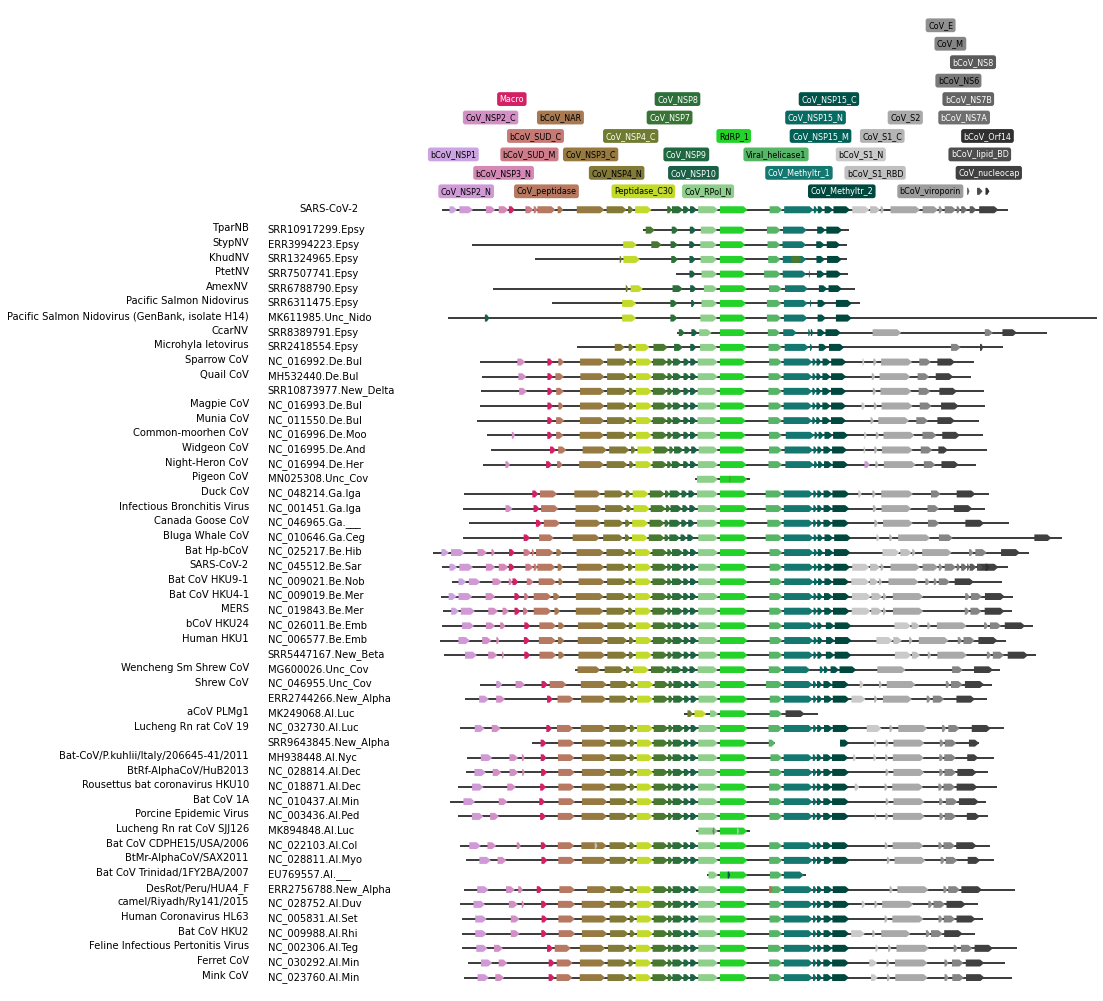

In [4]:
###### """ plotting code lives here  """
# this is the original submission figure

figure_width = 15

nb_plots = len(to_plot)
#nb_plots = 5
fig, subplots  = plt.subplots(
    nb_plots+1, 1, figsize=(figure_width, 3+.2*nb_plots), sharex=True, gridspec_kw={'height_ratios': [20] +[1]*nb_plots })
#plt.subplots_adjust(hspace  = 5)
subplot_i = 1

def hide_axes(ax,genome_start_pos,genome_end_pos):
    #hack: since I don't~~~~~ didn't know how to erase axes around coordinates, draw a white box over them.
    # is that a ugly hack? yes. does it render well? also yes
    ax.add_patch(
     patches.Rectangle(
        (-100, -0.25),
        genome_start_pos,
        0.5,
        fill=True,      # remove background
        facecolor='white'
     ) ) 
    ax.add_patch(
     patches.Rectangle(
        (genome_end_pos, -0.25),
        total_length+100,
        0.5,
        fill=True,      # remove background
        facecolor='white'
     ) ) 
    
# plot the virtual tracks for domain annotations
for virtual_track, v_subplot_i, annotation in \
    [(sc2_virtual_track,  0,          "SARS-CoV-2"), 
     #(nido_virtual_track, nb_plots+1, "Nido HMM")
    ]:
    record = GraphicRecord(sequence_length=total_length, feature_level_height=1, features=virtual_track)
    ax, _ = record.plot(ax=subplots[v_subplot_i], figure_width=figure_width)
    ax.set_facecolor("white")
    ax.annotate(annotation, (-2300,-0.1), xycoords='data', annotation_clip=False) #https://stackoverflow.com/questions/18537879/matplotlib-how-to-write-annotation-outside-the-drawing-in-data-coords
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
    genome_start_pos = rdrp_fixed_position - [x[0] for x in sars_cov_2_features if "RdRP" in x[3]][0]
    genome_end_pos = genome_start_pos + 29903
    hide_axes(ax,genome_start_pos,genome_end_pos)


all_names = set() # this is to keep track of all domains we encounter
#for accession, why in sorted(list(to_plot),key = lambda x:x[1])[:nb_plots]:
for accession in to_plot:
    
    #determine position of rdrp
    list_rdrp_positions = [x[0] for x in dgs[accession] if (x[3] == 'RdRP_1' \
                                                            and (accession not in multicontig_assemblies \
                                                                 or multicontig_assemblies[accession] in x[4]\
                                                                )\
                                                           )]

    if len(list_rdrp_positions) > 1:
        print("accession",accession,"has multiple rdrp's but no idea how to disambiguate")
        break
    elif len(list_rdrp_positions) == 1:
        rdrp_genome_position = list_rdrp_positions[0]
        rdrp_offset = rdrp_fixed_position - rdrp_genome_position
    else:
        print("accession",accession,"rdrp not found: ",[(x[3],x[4]) for x in dgs[accession]])
        rdrp_offset = 0
        rdrp_genome_position=rdrp_fixed_position
    
    features = []
    ctgs = set()
    for feature in dgs[accession]:
        start, end, strand, name, ctg, is_complete, pfam_hmm = feature
        
        if accession in multicontig_assemblies:
            if multicontig_assemblies[accession] not in ctg: 
                # select only 1 contig in multi-contig assemblies
                continue
        ctgs.add(ctg[:-2])

        all_names.add(name)
        start, end = start+rdrp_offset, end+rdrp_offset # apply offset to line up rdrp's
        if name in dpalette:
            color = dpalette[name]
        elif pfam_hmm == "nido":
            color = nidopalette[nido_exclusives.index(name)]
        else:
            color = "red"
        linewidth = 0 if pfam_hmm == "sc2" else 1
        linecolor = "#EE0000"
        #print(accession,name,start,end)
        features += [GraphicFeature(start=start, end=end, strand=int(strand+"1"), color = color, 
                                    linewidth=linewidth, linecolor=linecolor, thickness=7)]
    if len(ctgs) > 1:
        print("warning!",accession,"has",len(ctgs),"contigs")
        
    record = GraphicRecord(sequence_length=total_length, feature_level_height=0, features=features)
    ax, _ = record.plot(ax=subplots[subplot_i], figure_width=figure_width)
    ax.set_facecolor("white")
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
    
    # display left text
    #https://stackoverflow.com/questions/18537879/matplotlib-how-to-write-annotation-outside-the-drawing-in-data-coords
    ax.annotate(("%15s" % taxlabels[accession]) ,(-4000,-2), xycoords='data', annotation_clip=False, ha='left') 
    #ax.annotate(('%6d nt' % genome_lengths[accession]) ,(-3500,-0.1), xycoords='data', annotation_clip=False, ha='right') 
    #ax.annotate(('OTU=%-12s' % why) ,(-2300,-0.1), xycoords='data', annotation_clip=False, ha='left') 
    if accession in descs:
        ax.annotate(('%s' % descs[accession]) ,(-5000,-0.1), xycoords='data', annotation_clip=False, ha='right') 
    
    # hide axis before/after true assembly positions
    genome_start_pos = rdrp_fixed_position - rdrp_genome_position
    genome_end_pos = genome_start_pos + genome_lengths[accession]
    hide_axes(ax,genome_start_pos,genome_end_pos)
    
    if accession == "SRR9643845":
        # surgery to indicate scaffolding
        ax.add_patch(
         patches.Rectangle(
            (rdrp_fixed_position + (12840 - rdrp_genome_position), -2.1),
            16272-12840,
            4,
            fill=True,      # remove background
            facecolor='white'
         ) ) 
    
    subplot_i += 1
    
    
fig.tight_layout(pad=-1)
fig.savefig('genome_structure.pdf', bbox_inches='tight')
fig.savefig('genome_structure.svg', bbox_inches='tight')

In [5]:
import sys
sys.executable

'/home/ec2-user/miniconda3/bin/python'

In [6]:
dgs["SRR6311475"]

[(3615,
  4362,
  '+',
  'Peptidase_C30',
  'SRR6311475.coronaspades.NODE_1_length_16230_cluster_1_candidate_1_domains_7_3',
  True,
  'sc2'),
 (6174,
  6555,
  '+',
  'CoV_NSP8',
  'SRR6311475.coronaspades.NODE_1_length_16230_cluster_1_candidate_1_domains_7_3',
  False,
  'sc2'),
 (7275,
  7476,
  '+',
  'CoV_NSP10',
  'SRR6311475.coronaspades.NODE_1_length_16230_cluster_1_candidate_1_domains_7_3',
  False,
  'sc2'),
 (7824,
  8655,
  '+',
  'CoV_RPol_N',
  'SRR6311475.coronaspades.NODE_1_length_16230_cluster_1_candidate_1_domains_7_2',
  True,
  'sc2'),
 (8802,
  10194,
  '+',
  'RdRP_1',
  'SRR6311475.coronaspades.NODE_1_length_16230_cluster_1_candidate_1_domains_7_2',
  True,
  'sc2'),
 (11295,
  12063,
  '+',
  'Viral_helicase1',
  'SRR6311475.coronaspades.NODE_1_length_16230_cluster_1_candidate_1_domains_7_2',
  True,
  'sc2'),
 (12198,
  13458,
  '+',
  'CoV_Methyltr_1',
  'SRR6311475.coronaspades.NODE_1_length_16230_cluster_1_candidate_1_domains_7_2',
  True,
  'sc2'),
 (13584,

data loaded ok 32 genomes to plot
['ERR3994143.NODE_2_length_10261_cov_204', 'nb2-SRR6311475AK.NODE_47_length_1968_cluster_44_candidate_1_domains_1', 'ERR3994141.NODE_3_length_10277_cov_183', 'SRR7507741.NODE_76_length_9403_cov_314', 'SRR6788788.NODE_17_length_12929_cov_474', 'SRR9211912.NODE_1196_length_4736_cov_14', 'ERR3994223.NODE_2_length_10257_cov_392', 'SRR6788807.NODE_28_length_12483_cov_34', 'SRR6788791.NODE_16_length_12528_cov_537', 'SRR6788790.NODE_11_length_12596_cov_95', 'SRR10917299.NODE_45_length_11374_cov_265', 'SRR6788775.NODE_23_length_13032_cov_64', 'SRR6788782.NODE_6_length_12952_cov_82', 'SRR8389847.NODE_2_length_17948_cov_325', 'SRR8389791.NODE_1_length_19663_cov_257', 'SRR10917302.NODE_62_length_10771_cov_46', 'SRR6788789.NODE_15_length_12572_cov_116', 'SRR9211911.NODE_139_length_8344_cov_33', 'SRR6788787.NODE_14_length_12917_cov_384', 'nb2-MK611985.MK611985', 'SRR6788779.NODE_10_length_12528_cov_41', 'ERR3994142.NODE_3_length_10259_cov_108', 'nb1-SRR5997671.NODE

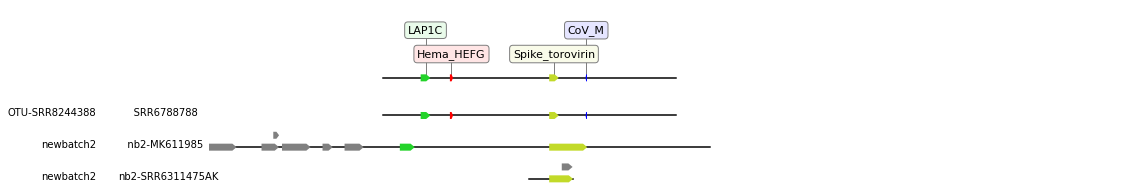

In [5]:
# additional figure bit for the epsys: the right side
# /home/ec2-user/master_table/epsy on the EC2 instance

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as clr
from dna_features_viewer import GraphicFeature, GraphicRecord
from foreground import get_foreground 
from collections import defaultdict

# import genome structure data
import marshal
marshal_filename = "genome_structure.epsys.data.marshal"
epgsdata = open(marshal_filename,'rb')
epsys_genome_structures = marshal.load(epgsdata)
epsys_dgs = dict(epsys_genome_structures)
epgsdata.close()
#epsys_genome_structures

# find otu of accession
import os
import glob
otuname = dict()
# a bit EC2-specific..
for file in glob.glob('/home/ec2-user/master_table/epsy/OTU-*/Epsy/*.fa') + glob.glob('/home/ec2-user/master_table/epsy/newbatch*/*.fa') :
    #if os.path.basename(file).endswith(".epsy.fa"):
        accession=os.path.basename(file).split('.')[0]
        otu=file.split('/')[5]
        #print(accession,otu,file)
        otuname[accession]=otu

def unsixframe(ctg):
    return '_'.join(ctg.split('_')[:-1])

to_plot = set()
epsy_contig = dict()
for accession in epsys_dgs:
    for feature in epsys_dgs[accession]:
        start, end, strand, name, ctg, is_complete = feature
        if name == "LAP1C" or name == "Spike_torovirin":
            epsy_contig[accession] = unsixframe(ctg)
            to_plot.add(accession)
for accession in epsys_dgs:
    epsys_dgs[accession] = filter_features(epsys_dgs[accession],False,False)

to_plot=list(to_plot)
print("data loaded ok", len(to_plot),"genomes to plot")
print(to_plot)
to_plot=sorted(to_plot,key=lambda x:otuname[x.split('.')[0]]+x)
to_plot=list(filter(lambda x :'nb2' in x or "SRR6788788" in x,to_plot)) # newbatch1-specific, uncomment to plot everything

# sets some important constants
total_length = 40000 #total length of displayed genomes (real genomes might be shorter)
figure_width = 15
spike_fixed_position = 15000 # put the Spike_torovirin here

nb_plots = len(to_plot)
fig, subplots  = plt.subplots(
    nb_plots+1, 1, figsize=(figure_width, 1+0.4*nb_plots), sharex=True, gridspec_kw={'height_ratios': [20] +[10]*nb_plots })
subplot_i = 1

for accession in to_plot:
    contig_length = None
    srr = accession.split('.')[0]
    
    spike_genome_position = [x[0] for x in epsys_dgs[accession] if "Spike_torovirin" in x[3]][0]
    spike_offset = spike_fixed_position - spike_genome_position
    
    # special case for the virtual track which gets plotted twice: at its right position and on top with labels
    for is_virtual_track in ([False] if srr != "SRR6788788" else [True,False]):
        features = []
        for feature in epsys_dgs[accession]:
            start, end, strand, name, ctg, is_complete = feature

            start, end = start+spike_offset, end+spike_offset # apply offset to line up Spike_torovirin

            if unsixframe(ctg) != epsy_contig[accession]: continue
            contig_length = int(ctg.split('_')[3]) # very SPAdes-specific, e.g. "NODE_1196_length_4736_cov_14.023161_2"
            #print(accession,ctg,name)
            color = "grey" # for now
            if name in ['Spike_torovirin','LAP1C','Hema_HEFG','CoV_M','Arteri_Gl']:
                color={'Spike_torovirin':"#c2da29",'LAP1C':"#23d32a",'Hema_HEFG':"red",'CoV_M':"blue",'Arteri_Gl':'orange'}[name]
            linewidth = 0 #if pfam_hmm == "sc2" else 1
            linecolor = "#000000"
            #print(accession,name,start,end)
            features += [GraphicFeature(start=start, end=end, strand=int(strand+"1"), color = color, 
                                        linewidth=linewidth, linecolor=linecolor, thickness=7, 
                                        label=None if not is_virtual_track else name)]
        
        record = GraphicRecord(sequence_length=total_length, feature_level_height=1, features=features)
        ax, _ = record.plot(ax=subplots[subplot_i if not is_virtual_track else 0], figure_width=figure_width,draw_line=False)
        ax.set_facecolor("white")
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
    
        genome_start_pos = spike_fixed_position - spike_genome_position
        genome_end_pos = genome_start_pos + contig_length
        ax.plot([genome_start_pos, genome_end_pos], [0, 0], zorder=-1000, c="k")
    
    # display left text
    ax.annotate(("%15s" % srr) ,(-4000,-0), xycoords='data', annotation_clip=False, ha='left') 
    ax.annotate(('%s' % otuname[srr]) ,(-5000,-0), xycoords='data', annotation_clip=False, ha='right') 
    #if accession in descs:
    #    ax.annotate(('%s' % descs[accession]) ,(-5000,-0.1), xycoords='data', annotation_clip=False, ha='right') 
        
    subplot_i += 1
    
fig.tight_layout(pad=-1)
fig.savefig('genome_structure.epsys.seg2.pdf', bbox_inches='tight')
fig.savefig('genome_structure.epsys.seg2.svg', bbox_inches='tight')

38 genomes to plot
unknown gene AAA_12
unknown gene AAA_12
unknown gene LAP1C
unknown gene Spike_torovirin
unknown gene AAA_12
unknown gene AAA_12


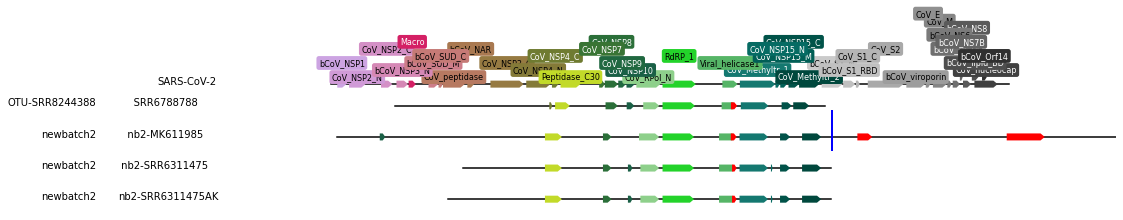

In [6]:
# the first segment of the epsys
# based off the original plotting code, with virtual track

to_plot = set()
epsy_contig = dict()
for accession in epsys_dgs:
    for feature in epsys_dgs[accession]:
        start, end, strand, name, ctg, is_complete = feature
        if name == "RdRP_1":
            epsy_contig[accession] = unsixframe(ctg)
            to_plot.add(accession)

for accession in epsys_dgs:
    epsys_dgs[accession] = filter_features(epsys_dgs[accession],False,False)

to_plot=list(to_plot)
print(len(to_plot),"genomes to plot")
to_plot=sorted(to_plot,key=lambda x:otuname[x.split('.')[0]]+x)
to_plot=list(filter(lambda x :'nb2' in x or "SRR6788788" in x,to_plot)) # newbatch1-specific, uncomment to plot everything

figure_width = 15
nb_plots = len(to_plot)
fig, subplots  = plt.subplots(
    nb_plots+1, 1, figsize=(figure_width, 1+.4*nb_plots), sharex=True, gridspec_kw={'height_ratios': [20] +[10]*nb_plots })
subplot_i = 1

# plot the virtual tracks for domain annotations
## Evan Notes Here
for virtual_track, v_subplot_i, annotation in \
    [(sc2_virtual_track,  0,          "SARS-CoV-2")]:
    record = GraphicRecord(sequence_length=total_length, feature_level_height=1, features=virtual_track)
    ax, _ = record.plot(ax=subplots[v_subplot_i], figure_width=figure_width,draw_line=False) 
    ax.set_facecolor("white")
    ax.annotate(annotation, (-2300,-0.1), xycoords='data', annotation_clip=False) #https://stackoverflow.com/questions/18537879/matplotlib-how-to-write-annotation-outside-the-drawing-in-data-coords
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
    genome_start_pos = rdrp_fixed_position - [x[0] for x in sars_cov_2_features if "RdRP" in x[3]][0]
    genome_end_pos = genome_start_pos + 29903
    ax.plot([genome_start_pos, genome_end_pos], [0, 0], zorder=-1000, c="k") 
## Evan Notes Here

for accession in to_plot:
    srr = accession.split('.')[0]
    contig_length=None
    list_rdrp_positions = [x[0] for x in epsys_dgs[accession] if (x[3] == 'RdRP_1')]

    rdrp_genome_position = list_rdrp_positions[0]
    rdrp_offset = rdrp_fixed_position - rdrp_genome_position
    
    features = []
    for feature in epsys_dgs[accession]:
        start, end, strand, name, ctg, is_complete = feature
        contig_length = int(ctg.split('_')[3]) # very SPAdes-specific, e.g. "NODE_1196_length_4736_cov_14.023161_2"

        start, end = start+rdrp_offset, end+rdrp_offset # apply offset to line up rdrp's
        if name in dpalette:
            color = dpalette[name]
        else:
            color = "red"
            print("unknown gene",name)
        linewidth = 0
        linecolor = "#EE0000"
        #print(accession,name,start,end)
        features += [GraphicFeature(start=start, end=end, strand=int(strand+"1"), color = color, 
                                    linewidth=linewidth, linecolor=linecolor, thickness=7)]
    
    genome_start_pos = rdrp_fixed_position - rdrp_genome_position
    genome_end_pos = genome_start_pos + contig_length
    record = GraphicRecord(sequence_length=total_length, feature_level_height=0, features=features)
    ax, _ = record.plot(ax=subplots[subplot_i], figure_width=figure_width,draw_line=False)
    ax.plot([genome_start_pos, genome_end_pos], [0, 0], zorder=-1000, c="k")
    ax.set_facecolor("white")
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
    
    if accession == "nb2-MK611985.MK611985":
        ax.add_patch( patches.Rectangle( (genome_start_pos+21781, -1),
            21880-21781, 2, fill=True,  facecolor='blue') )          # surgery to indicate gap
    
    # display left text
    ax.annotate(("%15s" % srr) ,(-4000,-0), xycoords='data', annotation_clip=False, ha='left') 
    ax.annotate(('%s' % otuname[srr]) ,(-5000,-0), xycoords='data', annotation_clip=False, ha='right') 
        
    subplot_i += 1
    
fig.tight_layout(pad=-1)
fig.savefig('genome_structure.epsys.seg1.pdf', bbox_inches='tight')
fig.savefig('genome_structure.epsys.seg1.svg', bbox_inches='tight')

In [9]:
import matplotlib
matplotlib.__version__

'3.3.4'